In [53]:
import numpy as np
import numpy.matlib
from numpy import linalg as LA

from scipy import optimize as opt
import scipy.signal

from mpl_toolkits import mplot3d
from ripser import ripser
from persim import plot_diagrams
from scipy.spatial import distance_matrix
from scipy.spatial import distance
from matplotlib.ticker import StrMethodFormatter, FormatStrFormatter

from sklearn import metrics

import matplotlib.pyplot as plt
# %matplotlib inline

import cup_quasi_periodic_detection as cqpd
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
np.random.seed(10)

N = 5000

t = np.linspace(0, 200, N)

all_f = []

In [5]:
def f_h(t):
#     return 2*np.sin(t) + 1.5*np.sin(2*t)
#     return 1.1*np.exp(1j*t) + np.exp(1j*np.sqrt(3)*t)
    return 1*np.sin(2*t) + 2*np.sin(np.sqrt(3)*t)



In [94]:
t1 = np.linspace(0, 60*2*np.pi, 2000, endpoint=False)

curve1 = np.array([np.zeros(len(t1)), -np.sin(t1), 2 - np.cos(t1)]).transpose()

t2 = np.linspace(60*2*np.pi, 120*2*np.pi, 2000, endpoint=False)

angles = np.column_stack((t2, (1/60)*(1/2)*t2))

def s2 (phi, theta):
    x = np.cos(phi)*np.sin(theta)
    y = np.sin(phi)*np.sin(theta)
    z = np.cos(theta)
    
    return np.array([x,y,z])

curve2 = np.array([s2(l[0], l[1]) for l in angles])

t3 = np.linspace(120*2*np.pi, 180*2*np.pi, 2000, endpoint=False)

curve3 = np.array([np.sin(t3), np.zeros(len(t3)), -2 + np.cos(t3)]).transpose()

complete_t = np.row_stack((t1.reshape([-1,1]), t2.reshape([-1,1]), t3.reshape([-1,1])))

complete_curve = np.row_stack([curve1, curve2, curve3])

rng = np.random.default_rng()

x = .25*rng.random()
y = .25*rng.random()
z = .25*rng.random()

point = [1/4+x, 1/4+y, 1/4+z]
point = point/np.linalg.norm(point)

print(point)

# time_series = np.arccos(np.dot(complete_curve, point))

time_series = np.power(distance.cdist(complete_curve, [point]).reshape(-1), 2)

print(time_series.shape)

time_series = time_series - np.mean(time_series)

t = complete_t

[0.60371913 0.564144   0.56326261]
(6000,)


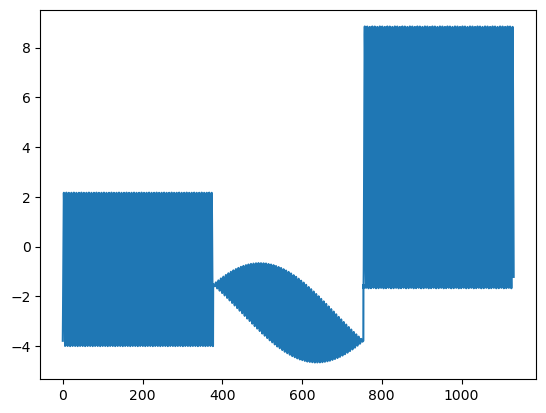

In [95]:
# plots
plt.plot(t, time_series)
# plt.savefig('roc_curves/plot_{}.png'.format(i))
plt.show()

3.686381006794268
[-1, 0, 1]
d= 3
tau= [4.71238898]
[[ 4.71238898]
 [14.13716694]
 [70.68583471]
 [23.5619449 ]]


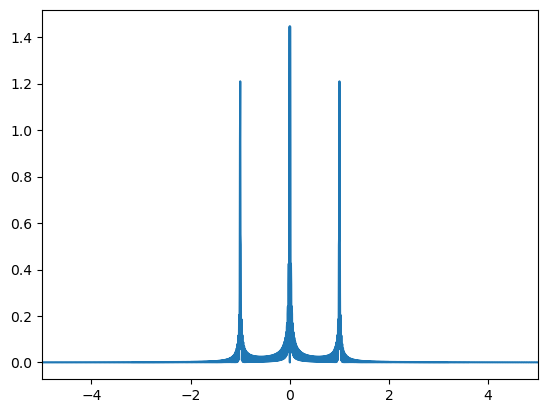

In [96]:
# time_series = f_h(t)
# print(LA.norm(time_series))
# time_series = time_series/LA.norm(time_series)
# print(LA.norm(time_series))

n_t = len(t)

delta_t = (t[-1] - t[0])/n_t

# f_hat = np.fft.fft(time_series, norm='ortho')
f_hat = np.fft.fft(time_series)
f_hat = np.fft.fftshift(f_hat)/n_t # Correct order for the frequencies

print(LA.norm(f_hat))

abs_f_hat = np.abs(f_hat)
# abs_f_hat = abs_f_hat/LA.norm(abs_f_hat[0:n_t//2])

freq = np.fft.fftfreq(n_t, d=delta_t/(2*np.pi))
freq = np.fft.fftshift(freq)

plt.plot(freq, abs_f_hat)
plt.xlim(-5,5)

ind, _ = scipy.signal.find_peaks(abs_f_hat, height=.1)



# ind += 1 

# k_dot_omega = freq[ind]

# k_dot_omega = [-2, -np.sqrt(3), np.sqrt(3), 2]

k_dot_omega = [-1, 0, 1]

print(k_dot_omega)
# if LA.norm(np.imag(time_series)) == 0:
#     k_dot_omega = np.concatenate((k_dot_omega, -k_dot_omega), axis=None)

# print(k_dot_omega)

x = t[0:len(t)//2]
    
if x[0] == 0:
    x = x[1:]
    
    
d = len(k_dot_omega)

    
print('d=',d)
k_dot_omega_diff = np.zeros(d*(d-1)//2)

k = 0

for i in range(d):
    for j in range(i+1,d):
        k_dot_omega_diff[k] = k_dot_omega[i] - k_dot_omega[j]
        k += 1

diff_dot_omega = k_dot_omega_diff.reshape((-1,1))

arg = np.dot(diff_dot_omega , x.reshape((1,-1)))

G = (1 - np.exp(1j*arg*(d+1)))/(1 - np.exp(1j*arg))

G = np.sum(np.abs(G)**2, axis=0)

# plt.plot(x,G)

tau = x[np.argmin(G)]
print('tau=',tau)

print(x[np.argsort(G)[0:4]])


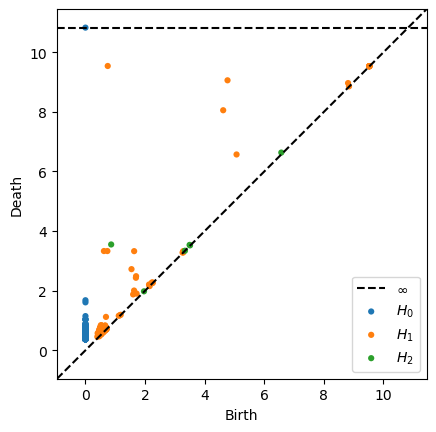

In [97]:
# tau, d = cqpd.optimal_tau2(time_series, t)

tau = x[np.argsort(G)[0]]

# pc = cqpd.SW(f_h, t, d, tau)

pc = cqpd.sw_map(time_series, t, d, tau, 10000)

dm_X = distance.cdist(pc, pc)

# # Maxmin subsampling

ind_L, cover_r = cqpd.maxmin(dm_X, 300)

dm_L = dm_X[ind_L,:][:,ind_L]

# # Persistent homology

q = 2

# result = ripser(dm_L, coeff=q, distance_matrix=True, maxdim=2, do_cocycles=True)

result = ripser(pc, coeff=q, maxdim=2, do_cocycles=True, n_perm=600)


diagrams = result['dgms']
cocycles = result['cocycles']

plt.close()
plot_diagrams(diagrams)
plt.show()

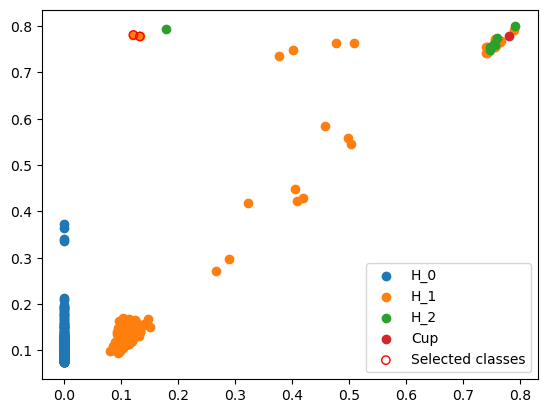

In [47]:
co1_ind=-1
co2_ind=-2

cup_bar = cqpd.getQuasiPeriodicScore(diagrams, cocycles, dm_L, coeff=q, cocycle_1_ind=co1_ind, cocycle_2_ind=co2_ind)

# Plot new diagrams

# Plot of persistent diagram + cup product

plt.scatter(diagrams[0][:,0], diagrams[0][:,1], label='H_0')
plt.scatter(diagrams[1][:,0], diagrams[1][:,1], label='H_1')
plt.scatter(diagrams[2][:,0], diagrams[2][:,1], label='H_2')

plt.scatter(cup_bar[0], cup_bar[1], label ='Cup')

H_1 = cocycles[1]
H_1_diagram = diagrams[1]
H_1_persistence = H_1_diagram[:,1] - H_1_diagram[:,0]
H_1_persistence_sort_ind = H_1_persistence.argsort()

chosen = diagrams[1][[H_1_persistence_sort_ind[co1_ind], H_1_persistence_sort_ind[co2_ind]],:]

plt.scatter(chosen[:,0], chosen[:,1], label='Selected classes', facecolors='none', edgecolors='r')

plt.legend(loc = 'lower right')

plt.savefig('roc_curves/cup_persistence_{}.png'.format(i))
plt.show()

In [48]:
roc_table = np.genfromtxt('roc_curves/results.csv',delimiter=',')

In [51]:
scores = np.sqrt(np.absolute(roc_table[:,0] - roc_table[:,1])*np.absolute(roc_table[:,2] - roc_table[:,3])/3)

In [52]:
y = roc_table[:,4]

In [59]:
fpr, tpr, tresh = metrics.roc_curve(y,scores)

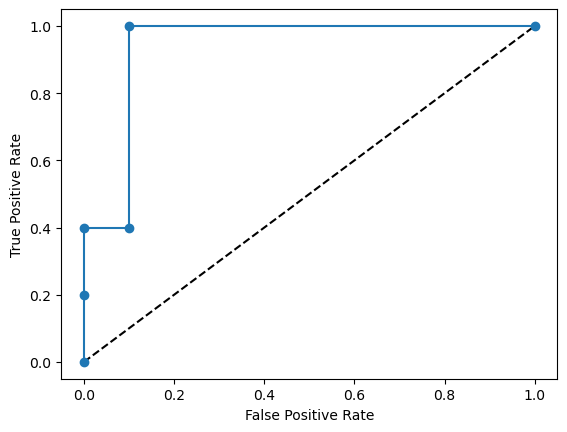

In [65]:
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr, 'o-')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.show()